In [1]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Merge, Activation, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk
import os
print(os.getcwd())

Using TensorFlow backend.


/Users/evanczyzycki/Desktop/595-valence-shifting-captions/Image-Captioning


In [2]:
token = 'Flickr8k_text/Flickr8k.token.txt'

In [3]:
captions = open(token, 'r').read().strip().split('\n')

In [4]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [5]:
# images = 'Flickr8k_Dataset/Flicker8k_Dataset/'
images = 'Flicker8k_Dataset/'

In [6]:
# Contains all the images
img = glob.glob(images+'*.jpg')

In [7]:
train_images_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'

In [8]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [9]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [10]:
# Getting the training images from all the images
train_img = split_data(train_images)

In [11]:
val_images_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [12]:
# Getting the validation images from all the images
val_img = split_data(val_images)

In [13]:
test_images_file = 'Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [14]:
# Getting the testing images from all the images
test_img = split_data(test_images)

In [15]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [16]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

In [17]:
model = InceptionV3(weights='imagenet')

In [18]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [19]:
tryi = model_new.predict(preprocess(train_img[0]))

In [20]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [21]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [22]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [23]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [24]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [25]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [26]:
caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [27]:
words = [i.split() for i in caps]

In [28]:
unique = []
for i in words:
    unique.extend(i)

In [29]:
unique = list(set(unique))

In [30]:
unique = pickle.load(open('unique.p', 'rb'))

In [31]:
word2idx = {val:index for index, val in enumerate(unique)}

In [32]:
idx2word = {index:val for index, val in enumerate(unique)}

In [33]:
max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)

In [34]:
vocab_size = len(unique)

In [35]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")

18

In [36]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [37]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [38]:
c = [i for i in df['captions']]

In [39]:
imgs = [i for i in df['image_id']]

In [40]:
samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [41]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0

In [42]:
embedding_size = 300

In [43]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

In [44]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

In [45]:
final_model = Sequential([
        Merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

In [46]:
final_model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [47]:
final_model.load_weights('./weights/time_inceptionV3_1.5987_loss.h5')

In [48]:
def predict_captions(image):
    start_word = ["<start>"]
    encoded_image = encode(image)
    while True:
        par_caps = [word2idx[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        e = encoded_image
        preds = final_model.predict([np.array([e]), np.array(par_caps)])
        word_pred = idx2word[np.argmax(preds[0])]
        start_word.append(word_pred)
        
        if word_pred == "<end>" or len(start_word) > max_len:
            break
            
    return ' '.join(start_word[1:-1])

In [49]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    
    start_word = [[start, 0.0]]
    encoded_image = encode(image)

    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            e = encoded_image
            preds = final_model.predict([np.array([e]), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [50]:
from finalSentenceShifter import individualSentenceGeneration
def gen_captions(image):
    caption = predict_captions(image)
    print("Original caption: ", caption)

    individualSentenceGeneration(caption)


Original caption:  A snowboarder doing a jump on a ramp .
Finished loading opinion words
neut: A  snowboarder doing a  jump on a  ramp . 

pos: A nice snowboarder doing a minimal jump on a slight ramp . 

neg: A  snowboarder doing a significant jump on a crazy ramp . 



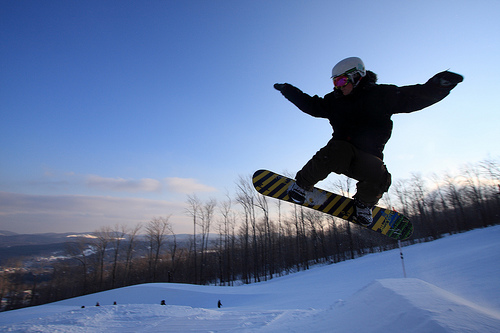

In [51]:
im = 'Flicker8k_Dataset/3214237686_6566b8b52f.jpg'
gen_captions(im)
Image.open(im)

Original caption:  A man wearing a helmet and sunglasses is doing a trick on a bicycle .
Finished loading opinion words
neut: A  man wearing a  helmet and  sunglasses is doing a  trick on a  bicycle . 

pos: A large man wearing a modular helmet and nice sunglasses is doing a magic trick on a giant bicycle . 

neg: A average man wearing a exist helmet and cheap sunglasses is doing a real trick on a small bicycle . 



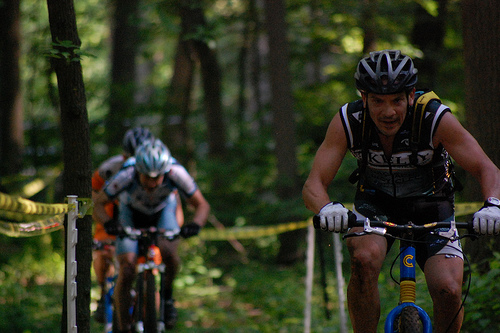

In [52]:
im = './Flicker8k_Dataset/3584534971_b44f82c4b9.jpg'
gen_captions(im)
Image.open(im)

Original caption:  A group of men play soccer .
Finished loading opinion words
neut: A  group of  men play  soccer . 

pos: A smaller group of large men play high soccer . 

neg: A small group of middle men play sof soccer . 



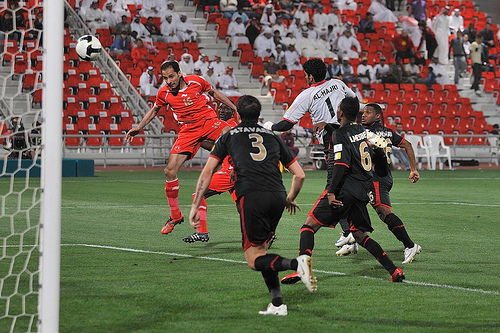

In [53]:
im = 'Flicker8k_Dataset/3317073508_7e13565c1b.jpg'
gen_captions(im)
Image.open(im)

Original caption:  A man is standing in water near a lake
Finished loading opinion words
neut: A  man is standing in  water near a  lake 

pos: A tall man is standing in boiling water near a frozen lake 

neg: A real man is standing in dirty water near a small lake 



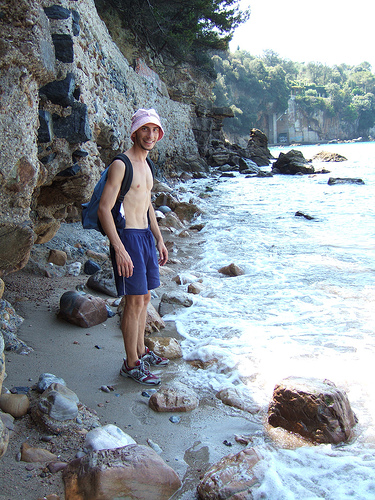

In [54]:
im = './Flicker8k_Dataset/2162564553_96de62c7e6.jpg'
gen_captions(im)
Image.open(im)

Original caption:  A group of people sit at a lit table outside a building .
Finished loading opinion words
neut: A  group of  people sit at a lit  table outside a  building . 

pos: A separate group of many people sit at a lit little table outside a old building . 

neg: A big group of normal people sit at a lit big table outside a whole building . 



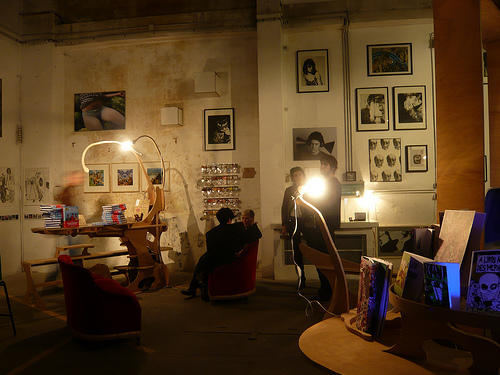

In [55]:
im = './Flicker8k_Dataset/2575647360_f5de38c751.jpg'
gen_captions(im)
Image.open(im)